In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import os
import sys
from typing import Dict, Any
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4
# from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

import matplotlib.pyplot as plt

/home/mak/Documents/Optimization/Project


In [2]:
# === File paths you must set ===
FIELDS = "../../data/processed/illinois_corn_fields_clean.csv"
WEATHER = "../../data/processed/noaa_il_weekly_clean.csv"
LABOR = "../../data/processed/labor_illinois_yearly_clean.csv"
MASTER = "../../data/processed/master_weekly_table.csv"

In [3]:
import pandas as pd

df = pd.read_csv("../../data/processed/labor_weekly_capacity_clean.csv")
df.head()
df.columns

Index(['year', 'week', 'labor_hours'], dtype='object')

In [ ]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# # Your v4 model
# from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4

# # === CONFIG ===
# n_simulations = 1000
# target_year = 2017

# # SAME PATHS YOU USED BEFORE
# field_path = "../../data/processed/illinois_corn_fields_clean.csv"
# weekly_base_path = "../../data/processed/master_weekly_table_labor_2017_2024_tightened.csv"
# results_out = "../../data/processed/monte_carlo_resultsv3.csv"

# base_params = {
#     "base_planter_capacity": 750.0,
#     "base_harvester_capacity": 450.0,
#     "labor_plant_per_acre": 0.2,
#     "labor_harvest_per_acre": 0.30,
#     "early_penalty_weight": 10.0,
#     "late_penalty_weight": 5.0,
#     "statewide_corn_acres": 12_000_000,
#     "time_limit": 60,
# }

# simulation_results = []

# print("Launching Monte Carlo simulations...\n")

# # === LOOP ===
# for sim in tqdm(range(n_simulations)):
    
#     # Load weekly base table
#     wm_df = pd.read_csv(weekly_base_path)

#     # Keep only the target year
#     wm_yr = wm_df[wm_df["year"] == target_year].copy()

#     # === Ensure column exists ===
#     if "harvest_weather_factor" not in wm_yr.columns:
#         wm_yr["harvest_weather_factor"] = 1.0

#     # -------------------------------------------------------------------
#     # 1) LABOR UNCERTAINTY (Normal shock ±20%)
#     # -------------------------------------------------------------------
#     labor_shock = np.random.normal(loc=1.0, scale=0.20, size=len(wm_yr))
#     wm_yr["labor_hours"] = wm_yr["labor_hours"] * labor_shock
#     wm_yr["labor_hours"] = wm_yr["labor_hours"].clip(lower=0)

#     # -------------------------------------------------------------------
#     # 2) WEATHER UNCERTAINTY — heavy rain makes capacity drop
#     #    - randomly select 4 weeks to "rain"
#     # -------------------------------------------------------------------
#     rain_weeks = np.random.choice(wm_yr["week"], size=4, replace=False)
    
#     # If precip column exists, use multiplicative noise
#     if "prcp_week_in" in wm_yr.columns:
#         noise = np.random.lognormal(mean=0, sigma=0.25, size=len(wm_yr))
#         wm_yr["prcp_week_in_sim"] = wm_yr["prcp_week_in"] * noise
#         wm_yr["capacity_factor"] = wm_yr["prcp_week_in_sim"].apply(lambda x: max(0, 1 - 0.18 * x))
#     else:
#         # fallback if precip is not available
#         wm_yr["capacity_factor"] = 1.0

#     # RAIN WEEKS: reduce harvest weather factor
#     wm_yr.loc[wm_yr["week"].isin(rain_weeks), "harvest_weather_factor"] *= 0.7

#     # -------------------------------------------------------------------
#     # 3) Write temporary file for v4 MILP
#     # -------------------------------------------------------------------
#     sim_path = f"../../data/processed/mc_runsv3/master_weekly_sim_{sim}.csv"
#     wm_df.loc[wm_df["year"] == target_year, "labor_hours"] = wm_yr["labor_hours"]
#     wm_df.loc[wm_df["year"] == target_year, "harvest_weather_factor"] = wm_yr["harvest_weather_factor"]
    
#     if "capacity_factor" in wm_yr.columns:
#         wm_df.loc[wm_df["year"] == target_year, "capacity_factor"] = wm_yr["capacity_factor"]
    
#     wm_df.to_csv(sim_path, index=False)

#     # -------------------------------------------------------------------
#     # 4) RUN v4 MILP SCHEDULER
#     # -------------------------------------------------------------------
#     try:
#         result_df = build_and_solve_schedule_v4(
#             fields_path=field_path,
#             weekly_master_path=sim_path,
#             target_year=target_year,
#             **base_params,
#         )

#         # Define makespan consistently
#         makespan = result_df["objective_makespan"].max()
#         total_penalty = result_df["penalty"].sum()
#         late_harvests = (result_df["harvest_week"] > result_df["harvest_week"].max() - 2).sum()

#         simulation_results.append({
#             "sim_id": sim,
#             "makespan": makespan,
#             "total_penalty": total_penalty,
#             "late_harvests": late_harvests,
#             "status": "OK",
#             "error": None
#         })

#     except Exception as e:
#         simulation_results.append({
#             "sim_id": sim,
#             "makespan": None,
#             "total_penalty": None,
#             "late_harvests": None,
#             "status": "ERROR",
#             "error": str(e),
#         })

# # === SAVE RESULTS ===
# results_df = pd.DataFrame(simulation_results)
# results_df.to_csv(results_out, index=False)

# print(f"\nMonte Carlo Completed. Saved results to: {results_out}")
# results_df.head()


Launching Monte Carlo simulations...



  0%|          | 0/1000 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/master_weekly_table_labor_2017_2024_tightened.csv'

In [4]:
# # =========================================================
# # MONTE CARLO ANALYSIS REPORT — FOR MILP v4 SIMULATION
# # =========================================================

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.style.use("seaborn-v0_8-whitegrid")

# RESULTS_PATH = "../../data/processed/monte_carlo_resultsv3.csv"

# # Load results
# df = pd.read_csv(RESULTS_PATH)

# # Filter only successful runs
# df_ok = df[df["status"] == "OK"].copy()

# print(f"📌 Total simulations: {len(df)}")
# print(f"✔ Feasible: {len(df_ok)}")
# print(f"❌ Infeasible: {len(df) - len(df_ok)}")

# # =========================================================
# # 1) SUMMARY STATISTICS
# # =========================================================

# summary = df_ok[["makespan", "total_penalty", "late_harvests"]].describe().T
# summary["variance"] = summary["std"] ** 2

# print("\n================ SUMMARY STATISTICS ================\n")
# display(summary)

# # =========================================================
# # 2) DISTRIBUTIONS
# # =========================================================

# fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# sns.histplot(df_ok["makespan"], kde=True, bins=15, color="royalblue", ax=axs[0])
# axs[0].set_title("Distribution of Makespan")
# axs[0].set_xlabel("Makespan (weeks)")

# sns.histplot(df_ok["total_penalty"], kde=True, bins=15, color="darkred", ax=axs[1])
# axs[1].set_title("Distribution of Penalty")
# axs[1].set_xlabel("Total Penalty")

# sns.histplot(df_ok["late_harvests"], kde=True, bins=15, color="darkgreen", ax=axs[2])
# axs[2].set_title("Distribution of Late Harvests")
# axs[2].set_xlabel("Late Harvest Count")

# plt.tight_layout()
# plt.show()

# # =========================================================
# # 3) BOXPLOTS
# # =========================================================

# fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# sns.boxplot(df_ok["makespan"], color="royalblue", ax=axs[0])
# axs[0].set_title("Makespan Distribution")

# sns.boxplot(df_ok["total_penalty"], color="darkred", ax=axs[1])
# axs[1].set_title("Penalty Distribution")

# plt.tight_layout()
# plt.show()

# # =========================================================
# # 4) RISK CURVES (CDF)
# # =========================================================

# sorted_makespan = np.sort(df_ok["makespan"])
# cdf = np.arange(len(sorted_makespan)) / float(len(sorted_makespan))

# plt.figure(figsize=(8, 6))
# plt.plot(sorted_makespan, cdf, linewidth=2)
# plt.xlabel("Makespan (weeks)")
# plt.ylabel("Cumulative Probability")
# plt.title("Risk Curve: Makespan CDF")
# plt.grid(True)
# plt.show()

# # Key percentiles
# percentiles = [50, 75, 90, 95, 99]
# risk_stats = {p: np.percentile(df_ok["makespan"], p) for p in percentiles}

# print("\n=============== RISK LEVELS (MAKESPAN) ===============")
# for p, val in risk_stats.items():
#     print(f"{p}th percentile: {val:.2f} weeks")

# # =========================================================
# # 5) CORRELATION ANALYSIS
# # =========================================================

# plt.figure(figsize=(6, 5))
# sns.heatmap(df_ok[["makespan", "total_penalty", "late_harvests"]].corr(), annot=True, cmap="coolwarm")
# plt.title("Correlation Heatmap")
# plt.show()

# # Scatter plots
# fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# sns.scatterplot(data=df_ok, x="late_harvests", y="makespan", ax=axs[0])
# axs[0].set_title("Makespan vs Late Harvests")

# sns.scatterplot(data=df_ok, x="makespan", y="total_penalty", ax=axs[1])
# axs[1].set_title("Penalty vs Makespan")

# plt.tight_layout()
# plt.show()

# # =========================================================
# # 6) BEST & WORST CASES
# # =========================================================

# best_5 = df_ok.sort_values("makespan").head(5)
# worst_5 = df_ok.sort_values("makespan").tail(5)

# print("\n=============== BEST 5 SCENARIOS ===============")
# display(best_5)

# print("\n=============== WORST 5 SCENARIOS ===============")
# display(worst_5)

# # =========================================================
# # 7) STRESS TEST INTERPRETATION
# # =========================================================

# print("\n=============== STRESS-TEST SUMMARY ===============")
# print(f"- Average makespan: {df_ok['makespan'].mean():.2f} weeks")
# print(f"- Worst-case makespan: {df_ok['makespan'].max():.2f} weeks")
# print(f"- Probability makespan exceeds 40 weeks: {(df_ok['makespan'] > 40).mean()*100:.1f}%")
# print(f"- Correlation (late harvests → makespan): {df_ok['late_harvests'].corr(df_ok['makespan']):.3f}")

# if df_ok["total_penalty"].sum() == 0:
#     print("- No moisture penalty triggered in any scenario (common if your PWL curve is mild).")
# else:
#     print("- Penalties were triggered — investigate moisture penalty curve.")


In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from typing import Optional

# =============================
# Import your v5 MILP model
# =============================
from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5


# =============================
# CONFIG
# =============================
N_SIM = 100
TARGET_YEAR = 2017

FIELD_PATH  = "../../data/processed/illinois_corn_fields_clean.csv"
MASTER_BASE = "../../data/processed/master_weekly_table_2017_2024.csv"
OUTPUT_CSV  = "../../data/processed/monte_carlo_results_v5.csv"
TMP_FOLDER  = "../../data/processed/mc_v5/"

os.makedirs(TMP_FOLDER, exist_ok=True)

base_params = {
    "base_planter_capacity": 500.0,
    "base_harvester_capacity": 250.0,
    "labor_plant_per_acre": 0.2,
    "labor_harvest_per_acre": 0.3,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 90,
}


# =============================
#  HELPER – Compute new capacity from rainfall
# =============================
def capacity_from_rain(prcp_week_in):
    if prcp_week_in < 0.5:
        return 1.0
    if prcp_week_in < 1.5:
        return 0.8
    if prcp_week_in < 3.0:
        return 0.5
    return 0.25


# =============================
# MAIN MONTE CARLO LOOP
# =============================
results = []

print(f"🔄 Running {N_SIM} Monte Carlo scenarios...\n")

for sim in tqdm(range(N_SIM)):

    # Load base master table
    wm = pd.read_csv(MASTER_BASE)
    wm_year = wm[wm["year"] == TARGET_YEAR].copy()

    # =====================================================
    # 1) LABOR SHOCK (normal ±20%)
    # =====================================================
    labor_noise = np.random.normal(1.0, 0.20, size=len(wm_year))
    wm_year["labor_hours"] = (wm_year["labor_hours"] * labor_noise).clip(lower=0)

    # =====================================================
    # 2) RAIN LOGNORMAL SHOCK + re-derive capacity
    # =====================================================
    if "prcp_week_in" in wm_year.columns:
        rain_noise = np.random.lognormal(mean=0, sigma=0.30, size=len(wm_year))
        wm_year["prcp_sim"] = wm_year["prcp_week_in"] * rain_noise
        wm_year["capacity_factor"] = wm_year["prcp_sim"].apply(capacity_from_rain)
    else:
        wm_year["capacity_factor"] = 1.0

    # =====================================================
    # 3) HARVEST WEATHER FACTOR — recompute using your function
    # =====================================================
    from src.optimization.milp_schedulerv5 import compute_harvest_weather_factor
    wm_year["harvest_weather_factor"] = wm_year.apply(
        compute_harvest_weather_factor, axis=1
    )

    # =====================================================
    # 4) RANDOM "WET WEEKS" (3–5 weeks)
    # =====================================================
    wet_weeks = np.random.choice(wm_year["week"], size=np.random.randint(3, 6), replace=False)
    wm_year.loc[wm_year["week"].isin(wet_weeks), "capacity_factor"] *= 0.7
    wm_year.loc[wm_year["week"].isin(wet_weeks), "harvest_weather_factor"] *= 0.75

    # =====================================================
    # 5) RANDOM MACHINE DOWNTIME (optional realism)
    # =====================================================
    if np.random.rand() < 0.25:  # 25% chance
        w_down = int(np.random.choice(wm_year["week"]))
        wm_year.loc[wm_year["week"] == w_down, "capacity_factor"] *= 0.5

    # =====================================================
    # 6) Write this simulation to file
    # =====================================================
    sim_path = f"{TMP_FOLDER}/weekly_sim_{sim}.csv"
    wm.loc[wm["year"] == TARGET_YEAR, wm_year.columns] = wm_year.values
    wm.to_csv(sim_path, index=False)

    # =====================================================
    # 7) RUN MILP (v5)
    # =====================================================
    try:
        df_res = build_and_solve_schedule_v5(
            fields_path=FIELD_PATH,
            weekly_master_path=sim_path,
            target_year=TARGET_YEAR,
            **base_params,
        )

        # If infeasible, the model returns {error: infeasible}
        if "error" in df_res.columns:
            results.append({
                "sim": sim,
                "makespan": None,
                "total_penalty": None,
                "late_harvests": None,
                "status": "INFEASIBLE"
            })
            continue

        # Extract metrics
        makespan = df_res["makespan"].max()
        total_penalty = df_res["early_penalty"].sum() + df_res["late_penalty"].sum()
        late_count = (df_res["status"] == "LATE").sum()

        results.append({
            "sim": sim,
            "makespan": makespan,
            "total_penalty": total_penalty,
            "late_harvests": late_count,
            "status": "OK",
        })

    except Exception as e:
        results.append({
            "sim": sim,
            "makespan": None,
            "total_penalty": None,
            "late_harvests": None,
            "status": "ERROR",
            "error": str(e)
        })


# =============================
# SAVE RESULTS
# =============================
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n🎉 Monte Carlo complete! Saved to: {OUTPUT_CSV}")
results_df.head()


🔄 Running 100 Monte Carlo scenarios...



  0%|          | 0/100 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x946066ce
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e

  1%|          | 1/100 [00:12<20:11, 12.24s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x5d3c5639
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 172 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Nod

  2%|▏         | 2/100 [00:13<09:13,  5.64s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x063eb607
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 181 iterations, 0.00 se

  3%|▎         | 3/100 [01:01<40:16, 24.91s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x04fae384
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 163 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

  4%|▍         | 4/100 [01:01<24:19, 15.20s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x20fe795d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 186 iterations, 0.

  5%|▌         | 5/100 [01:03<16:48, 10.61s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x778769c3
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 99 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node

  6%|▌         | 6/100 [01:04<11:03,  7.06s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xca6f8e5d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 144 iterations, 0.00 seconds (0.00 

  7%|▋         | 7/100 [01:04<07:40,  4.95s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x9f91c590
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

  8%|▊         | 8/100 [01:07<06:34,  4.29s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xf9462a94
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 183 iterations, 0.

  9%|▉         | 9/100 [01:11<06:10,  4.07s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xc42cce2f
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 174 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 10%|█         | 10/100 [01:21<08:55,  5.95s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x72fda9d8
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 202 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 11%|█         | 11/100 [01:36<13:14,  8.92s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x62dc994c
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 174 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 12%|█▏        | 12/100 [01:37<09:14,  6.30s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xbae0831b
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 176 iterations, 0.00 seconds (0.00 

 13%|█▎        | 13/100 [01:38<06:53,  4.75s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xe4836823
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 169 iterations, 0.00 seconds (0.00 

 14%|█▍        | 14/100 [01:39<05:05,  3.56s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x7964a189
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 163 iterations, 0.00 seconds (0.00 

 15%|█▌        | 15/100 [01:40<04:09,  2.94s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xd1a9085e
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 166 iterations, 0.00 seconds (0.00 

 16%|█▌        | 16/100 [01:41<03:11,  2.28s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x24ccd547
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 17%|█▋        | 17/100 [02:43<28:11, 20.38s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x077cdcc0
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 197 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 18%|█▊        | 18/100 [02:47<20:46, 15.20s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x1fd0a1ca
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 197 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 19%|█▉        | 19/100 [03:04<21:23, 15.85s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x0b7bd3d1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 185 iterations, 0.

 20%|██        | 20/100 [03:20<21:12, 15.91s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x63092040
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 143 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 21%|██        | 21/100 [03:22<15:27, 11.75s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x25e9013d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 179 iterations, 0.00 se

 22%|██▏       | 22/100 [03:33<14:46, 11.36s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x819ae898
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 23%|██▎       | 23/100 [03:33<10:22,  8.08s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xfb00a3f2
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 198 iterations, 0.00 se

 24%|██▍       | 24/100 [03:36<08:14,  6.51s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xedc51e92
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 157 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 25%|██▌       | 25/100 [03:37<05:58,  4.78s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x39574baf
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 26%|██▌       | 26/100 [03:45<07:13,  5.86s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x617a243a
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 168 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 27%|██▋       | 27/100 [03:46<05:23,  4.43s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x23a20ec3
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 28%|██▊       | 28/100 [03:49<04:43,  3.94s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x7bfb201d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 156 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 29%|██▉       | 29/100 [03:50<03:33,  3.01s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x6db040e7
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 30%|███       | 30/100 [03:52<03:18,  2.84s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xde6db1a5
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 170 iterations, 0.

 31%|███       | 31/100 [04:01<05:19,  4.62s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x3c48b001
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 182 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 32%|███▏      | 32/100 [04:05<04:55,  4.34s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xece914a9
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 169 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 33%|███▎      | 33/100 [04:05<03:33,  3.19s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x73ac63da
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 126 iterations, 0.00 seconds (0.00 

 34%|███▍      | 34/100 [04:06<02:41,  2.45s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x89742b0f
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 112 iterations, 0.00 seconds (0.00 

 35%|███▌      | 35/100 [04:06<01:58,  1.83s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x0bf1403d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 187 iterations, 0.00 se

 36%|███▌      | 36/100 [04:19<05:29,  5.14s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x1ae9b88a
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 170 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 37%|███▋      | 37/100 [04:19<03:55,  3.73s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x648fa10a
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 149 iterations, 0.00 seconds (0.00 

 38%|███▊      | 38/100 [04:20<02:57,  2.87s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xfe856839
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 156 iterations, 0.00 seconds (0.00 

 39%|███▉      | 39/100 [04:39<07:42,  7.59s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x04c18c88
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 198 iterations, 0.00 se

 40%|████      | 40/100 [04:41<05:53,  5.89s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x727d3c90
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 161 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 41%|████      | 41/100 [04:41<04:08,  4.22s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x6c3d4f25
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 103 iterations, 0.00 seconds (0.00 

 42%|████▏     | 42/100 [04:41<02:55,  3.02s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x72cfd5c6
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 43%|████▎     | 43/100 [04:52<04:55,  5.19s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x7c48dd0b
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 158 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 44%|████▍     | 44/100 [04:53<03:48,  4.07s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x4f39792e
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 187 iterations, 0.00 se

 45%|████▌     | 45/100 [04:55<03:08,  3.43s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x67d1a0e2
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 165 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 46%|████▌     | 46/100 [04:56<02:17,  2.54s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xfb2fb624
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 189 iterations, 0.00 se

 47%|████▋     | 47/100 [05:08<04:52,  5.53s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x0c7e6a3e
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 165 iterations, 0.

 48%|████▊     | 48/100 [05:11<04:09,  4.80s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x53258d54
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 190 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 49%|████▉     | 49/100 [05:23<05:56,  6.99s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x97327d40
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 193 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 50%|█████     | 50/100 [05:40<08:11,  9.84s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x45561ff4
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 111 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 51%|█████     | 51/100 [05:40<05:44,  7.04s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xa121894d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 146 iterations, 0.00 seconds (0.00 

 52%|█████▏    | 52/100 [05:41<04:09,  5.20s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xe4740481
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 53%|█████▎    | 53/100 [05:43<03:21,  4.28s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x9040cfbf
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 177 iterations, 0.

 54%|█████▍    | 54/100 [05:56<05:07,  6.69s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xc3fb4d8f
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 188 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 55%|█████▌    | 55/100 [06:41<13:45, 18.35s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x692ba6ff
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 123 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 56%|█████▌    | 56/100 [06:42<09:38, 13.15s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x733dfee9
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 169 iterations, 0.00 seconds (0.00 

 57%|█████▋    | 57/100 [07:00<10:20, 14.43s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x6bf50e3e
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 138 iterations, 0.00 seconds (0.00 

 58%|█████▊    | 58/100 [07:00<07:14, 10.34s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xe3090fc6
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 119 iterations, 0.00 seconds (0.00 

 59%|█████▉    | 59/100 [07:01<05:06,  7.48s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x73b181c3
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 163 iterations, 0.00 seconds (0.00 

 60%|██████    | 60/100 [07:02<03:34,  5.37s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xf9fa1043
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 126 iterations, 0.00 seconds (0.00 

 61%|██████    | 61/100 [07:02<02:35,  3.98s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x06efb528
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 62%|██████▏   | 62/100 [07:28<06:39, 10.51s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x1b687bc5
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 177 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 63%|██████▎   | 63/100 [07:28<04:36,  7.48s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x26455cdf
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 64%|██████▍   | 64/100 [07:31<03:33,  5.92s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x3f0c2423
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 157 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 65%|██████▌   | 65/100 [07:32<02:33,  4.37s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xcb0117a1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 145 iterations, 0.00 seconds (0.00 

 66%|██████▌   | 66/100 [07:32<01:52,  3.31s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x0bacd22a
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 67%|██████▋   | 67/100 [07:39<02:20,  4.25s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x923ec733
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 198 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 68%|██████▊   | 68/100 [07:50<03:25,  6.41s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xc1e97ccd
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 134 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 69%|██████▉   | 69/100 [07:51<02:24,  4.65s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x907a1d50
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 70%|███████   | 70/100 [07:53<01:53,  3.79s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xbe097f76
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 189 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 71%|███████   | 71/100 [07:55<01:40,  3.48s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x22051906
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 178 iterations, 0.

 72%|███████▏  | 72/100 [08:02<02:06,  4.53s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x494237e1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 161 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 73%|███████▎  | 73/100 [10:17<19:37, 43.59s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x03948ee8
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 176 iterations, 0.00 seconds (0.00 

 74%|███████▍  | 74/100 [10:18<13:20, 30.80s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xab8c25e1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 169 iterations, 0.00 se

 75%|███████▌  | 75/100 [10:27<10:07, 24.28s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xacbba79c
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 166 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 76%|███████▌  | 76/100 [10:28<06:57, 17.41s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xf4c846e6
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 153 iterations, 0.00 seconds (0.00 

 77%|███████▋  | 77/100 [10:29<04:44, 12.39s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x06024ad8
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 160 iterations, 0.00 seconds (0.00 

 78%|███████▊  | 78/100 [10:30<03:13,  8.80s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x198305ab
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 136 iterations, 0.00 seconds (0.00 

 79%|███████▉  | 79/100 [10:31<02:15,  6.46s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xe4d4bb7f
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 80%|████████  | 80/100 [10:33<01:47,  5.40s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x94334457
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 163 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 81%|████████  | 81/100 [10:34<01:15,  3.99s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x5282fc4f
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 125 iterations, 0.00 seconds (0.00 

 82%|████████▏ | 82/100 [10:35<00:52,  2.92s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x7c5e1dc4
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 171 iterations, 0.00 seconds (0.00 

 83%|████████▎ | 83/100 [10:36<00:39,  2.34s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x98331241
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 193 iterations, 0.00 se

 84%|████████▍ | 84/100 [10:58<02:13,  8.35s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xd03703fe
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 109 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 85%|████████▌ | 85/100 [10:58<01:29,  5.94s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x67daf019
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 206 iterations, 0.00 seconds (0.00 

 86%|████████▌ | 86/100 [10:58<00:59,  4.22s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x7e5d0cb1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 199 iterations, 0.00 se

 87%|████████▋ | 87/100 [11:17<01:51,  8.54s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xc91bac1d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 137 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 88%|████████▊ | 88/100 [11:18<01:14,  6.21s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x8abd46f3
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 173 iterations, 0.00 seconds (0.00 

 89%|████████▉ | 89/100 [11:19<00:50,  4.63s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x9aec5c43
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 136 iterations, 0.00 seconds (0.00 

 90%|█████████ | 90/100 [11:21<00:38,  3.87s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x4f650e3a
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 193 iterations, 0.00 se

 91%|█████████ | 91/100 [11:28<00:43,  4.82s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x8d9f9e53
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 175 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 92%|█████████▏| 92/100 [12:58<04:03, 30.46s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x1211e653
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 183 iterations, 0.

 93%|█████████▎| 93/100 [13:01<02:34, 22.02s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x432121ea
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 184 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 94%|█████████▍| 94/100 [13:03<01:37, 16.28s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x6c15b85e
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 177 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 95%|█████████▌| 95/100 [13:16<01:15, 15.18s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xbee282b1
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 189 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 96%|█████████▌| 96/100 [13:34<01:04, 16.03s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x09a6cc8d
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: objective 3.200000e+01, 197 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 97%|█████████▋| 97/100 [15:04<01:54, 38.29s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x0e6c96cc
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

 98%|█████████▊| 98/100 [15:06<00:54, 27.30s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp
Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xa51eabe8
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: 

 99%|█████████▉| 99/100 [15:30<00:26, 26.47s/it]

Set parameter TimeLimit to value 90
Set parameter TimeLimit to value 90
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  90
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x81ab08ec
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Variable types: 101 continuous, 1525 integer (1475 binary)

Root relaxation: infeasible, 168 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

100%|██████████| 100/100 [15:32<00:00,  9.33s/it]

📄 !!!!!!!!!!IIS written to infeasible.ilp

🎉 Monte Carlo complete! Saved to: ../../data/processed/monte_carlo_results_v5.csv


,sim,makespan,total_penalty,late_harvests,status,error
0,0,42.999999,0.0,0.0,OK,NaN
1,1,NaN,NaN,NaN,INFEASIBLE,NaN
2,2,43.000000,0.0,0.0,OK,NaN
3,3,NaN,NaN,NaN,INFEASIBLE,NaN
4,4,44.000000,0.0,0.0,OK,NaN


📌 Total simulations: 100
✔ Feasible: 47
❌ Infeasible or error: 53


================ SUMMARY STATISTICS ================



,count,mean,std,min,25%,50%,75%,max,variance
makespan,47.0,43.468085,0.584252,41.999999,43.0,43.999999,44.0,44.0,0.341351
total_penalty,47.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
late_harvests,47.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


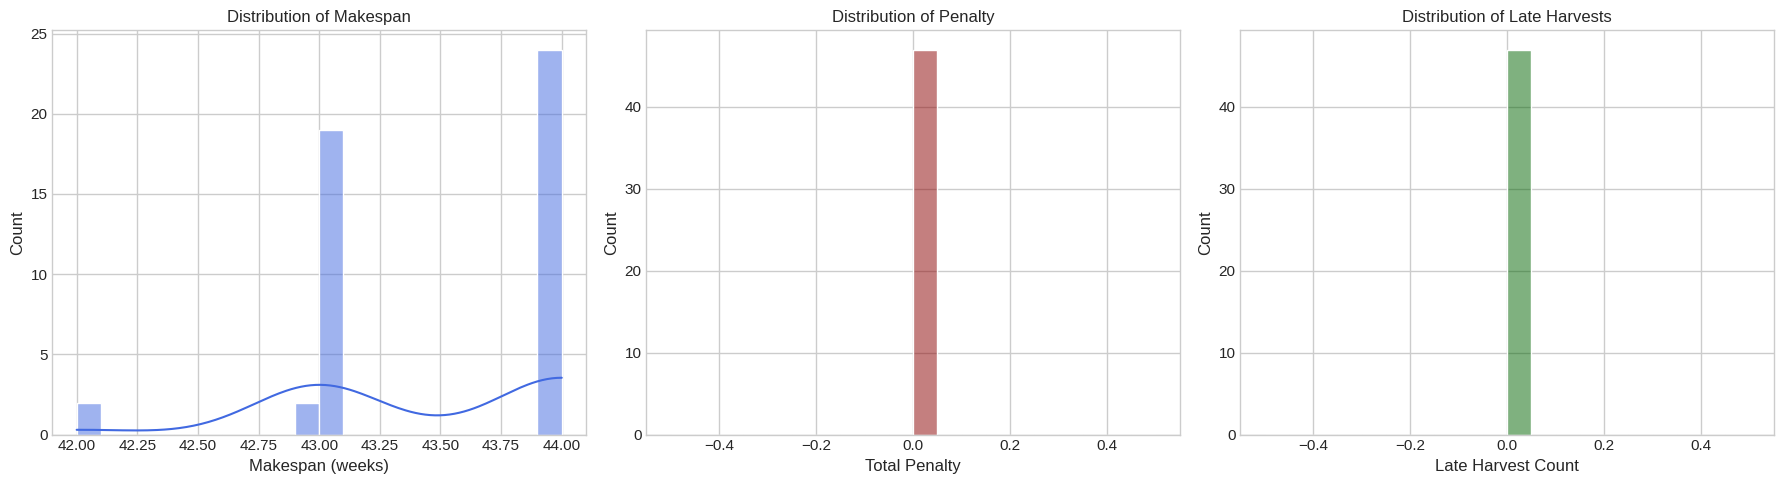

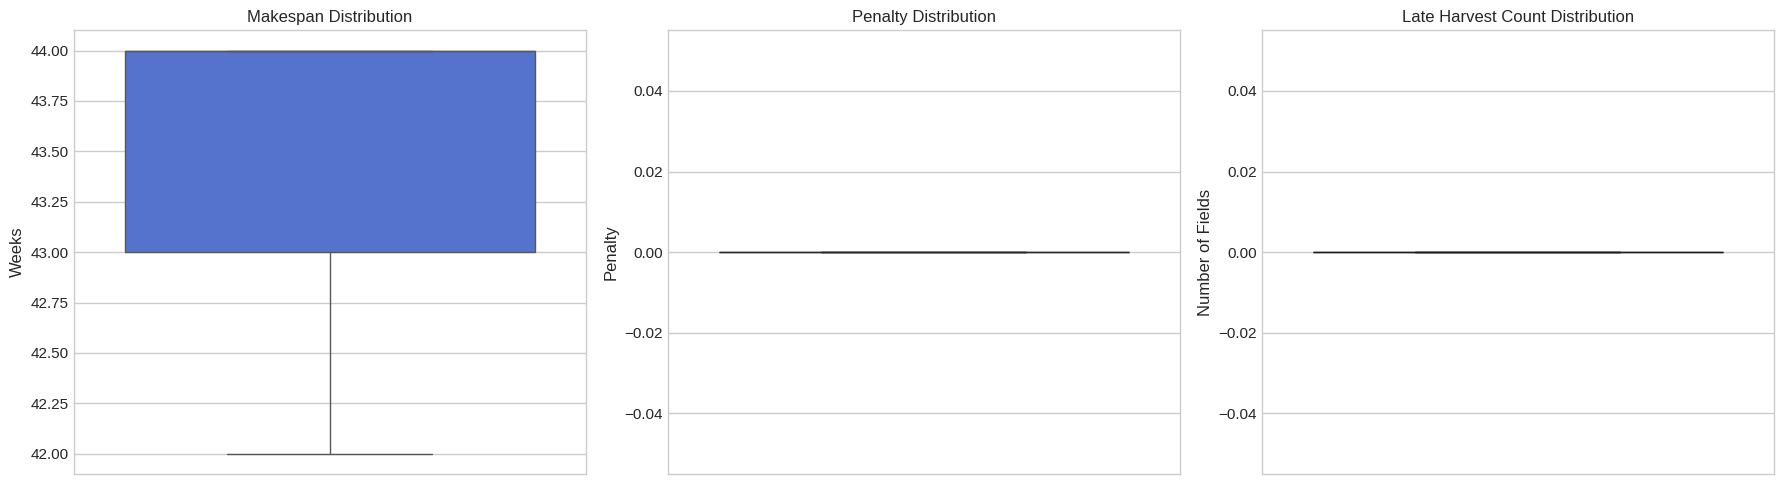

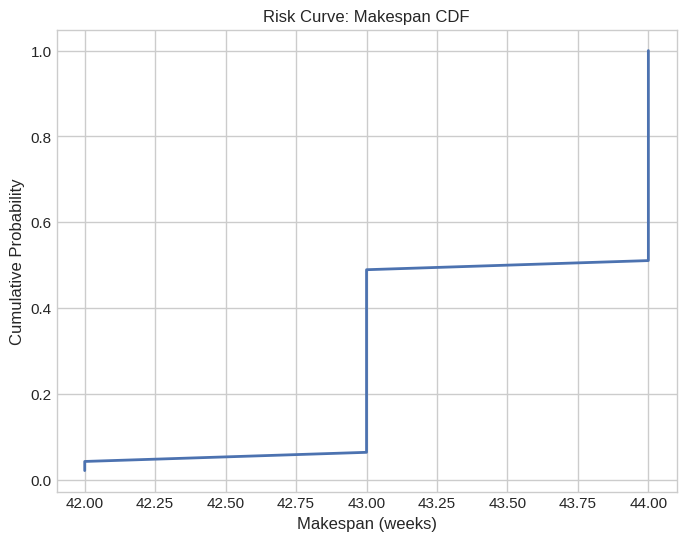


=============== RISK LEVELS (MAKESPAN) ===============
50th percentile: 44.00 weeks
75th percentile: 44.00 weeks
90th percentile: 44.00 weeks
95th percentile: 44.00 weeks
99th percentile: 44.00 weeks


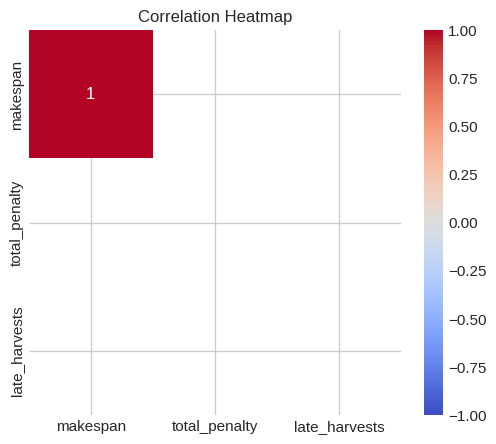

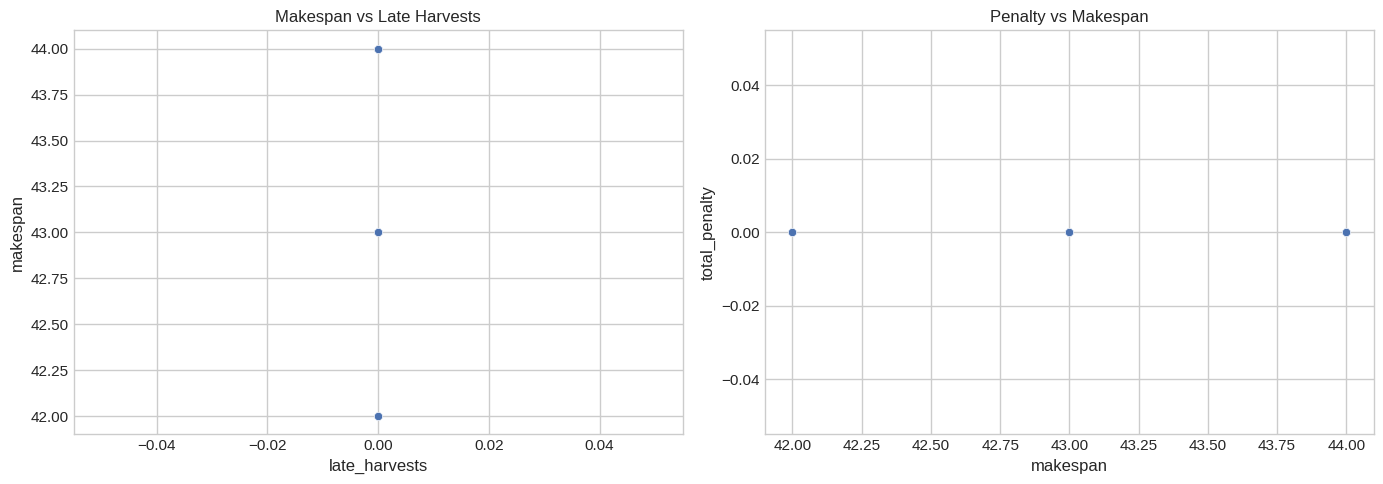


=============== BEST 5 SCENARIOS ===============


,sim,makespan,total_penalty,late_harvests,status,error
49,49,41.999999,0.0,0.0,OK,NaN
95,95,42.000000,0.0,0.0,OK,NaN
42,42,42.999997,0.0,0.0,OK,NaN
0,0,42.999999,0.0,0.0,OK,NaN
54,54,43.000000,0.0,0.0,OK,NaN



=============== WORST 5 SCENARIOS ===============


,sim,makespan,total_penalty,late_harvests,status,error
21,21,44.0,0.0,0.0,OK,NaN
25,25,44.0,0.0,0.0,OK,NaN
9,9,44.0,0.0,0.0,OK,NaN
71,71,44.0,0.0,0.0,OK,NaN
69,69,44.0,0.0,0.0,OK,NaN



=============== STRESS-TEST SUMMARY ===============

- Average makespan: 43.47 weeks
- Worst-case makespan: 44.00 weeks
- Probability makespan > 40 weeks: 100.0%
- Correlation (late_harvests → makespan): nan
- No penalty triggered. (Possible if window penalties are mild or weather is generous.)


/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [14]:
# =========================================================
# MONTE CARLO ANALYSIS REPORT — FOR MILP v5 SIMULATION
# =========================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

RESULTS_PATH = "../../data/processed/monte_carlo_results_v5.csv"

# =========================================================
# 0) LOAD + FILTER RESULTS
# =========================================================
df = pd.read_csv(RESULTS_PATH)

df_ok = df[df["status"] == "OK"].copy()
df_bad = df[df["status"] != "OK"]

print(f"📌 Total simulations: {len(df)}")
print(f"✔ Feasible: {len(df_ok)}")
print(f"❌ Infeasible or error: {len(df_bad)}\n")

# =========================================================
# 1) SUMMARY STATISTICS
# =========================================================

summary = df_ok[["makespan", "total_penalty", "late_harvests"]].describe().T
summary["variance"] = summary["std"] ** 2

print("\n================ SUMMARY STATISTICS ================\n")
display(summary)

# =========================================================
# 2) DISTRIBUTIONS
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_ok["makespan"], kde=True, bins=20, color="royalblue", ax=axs[0])
axs[0].set_title("Distribution of Makespan")
axs[0].set_xlabel("Makespan (weeks)")

sns.histplot(df_ok["total_penalty"], kde=True, bins=20, color="darkred", ax=axs[1])
axs[1].set_title("Distribution of Penalty")
axs[1].set_xlabel("Total Penalty")

sns.histplot(df_ok["late_harvests"], kde=True, bins=20, color="darkgreen", ax=axs[2])
axs[2].set_title("Distribution of Late Harvests")
axs[2].set_xlabel("Late Harvest Count")

plt.tight_layout()
plt.show()

# =========================================================
# 3) BOXPLOTS
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=df_ok["makespan"], color="royalblue", ax=axs[0])
axs[0].set_title("Makespan Distribution")
axs[0].set_ylabel("Weeks")

sns.boxplot(y=df_ok["total_penalty"], color="darkred", ax=axs[1])
axs[1].set_title("Penalty Distribution")
axs[1].set_ylabel("Penalty")

sns.boxplot(y=df_ok["late_harvests"], color="darkgreen", ax=axs[2])
axs[2].set_title("Late Harvest Count Distribution")
axs[2].set_ylabel("Number of Fields")

plt.tight_layout()
plt.show()

# =========================================================
# 4) RISK CURVE (CDF OF MAKESPAN)
# =========================================================

sorted_makespan = np.sort(df_ok["makespan"])
cdf = np.arange(1, len(sorted_makespan) + 1) / len(sorted_makespan)

plt.figure(figsize=(8, 6))
plt.plot(sorted_makespan, cdf, linewidth=2)
plt.xlabel("Makespan (weeks)")
plt.ylabel("Cumulative Probability")
plt.title("Risk Curve: Makespan CDF")
plt.grid(True)
plt.show()

# Key percentiles
percentiles = [50, 75, 90, 95, 99]
risk_stats = {p: np.percentile(df_ok["makespan"], p) for p in percentiles}

print("\n=============== RISK LEVELS (MAKESPAN) ===============")
for p, val in risk_stats.items():
    print(f"{p}th percentile: {val:.2f} weeks")

# =========================================================
# 5) CORRELATION ANALYSIS
# =========================================================

plt.figure(figsize=(6, 5))
sns.heatmap(df_ok[["makespan", "total_penalty", "late_harvests"]].corr(),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=df_ok, x="late_harvests", y="makespan", ax=axs[0])
axs[0].set_title("Makespan vs Late Harvests")

sns.scatterplot(data=df_ok, x="makespan", y="total_penalty", ax=axs[1])
axs[1].set_title("Penalty vs Makespan")

plt.tight_layout()
plt.show()

# =========================================================
# 6) BEST & WORST CASES
# =========================================================

best_5 = df_ok.sort_values("makespan").head(5)
worst_5 = df_ok.sort_values("makespan").tail(5)

print("\n=============== BEST 5 SCENARIOS ===============")
display(best_5)

print("\n=============== WORST 5 SCENARIOS ===============")
display(worst_5)

# =========================================================
# 7) STRESS TEST INTERPRETATION
# =========================================================

print("\n=============== STRESS-TEST SUMMARY ===============\n")
print(f"- Average makespan: {df_ok['makespan'].mean():.2f} weeks")
print(f"- Worst-case makespan: {df_ok['makespan'].max():.2f} weeks")
print(f"- Probability makespan > 40 weeks: {(df_ok['makespan'] > 40).mean()*100:.1f}%")
print(f"- Correlation (late_harvests → makespan): {df_ok['late_harvests'].corr(df_ok['makespan']):.3f}")

if df_ok["total_penalty"].sum() == 0:
    print("- No penalty triggered. (Possible if window penalties are mild or weather is generous.)")
else:
    print("- Penalties triggered — indicates early/late behavior or weather-driven delay.\n")


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_late_harvest_heatmap_v5(results_path: str):
    """
    Heatmap/barplot showing how often each 'late_harvests' count occurs
    across successful MILP v5 Monte Carlo simulations.
    """

    # Load results
    df = pd.read_csv(results_path)

    # Filter only feasible runs
    df_ok = df[df["status"] == "OK"]

    if "late_harvests" not in df_ok.columns:
        raise ValueError("late_harvests column missing from results file.")

    # Count occurrences of each late_harvests value
    late_counts = df_ok["late_harvests"].value_counts().sort_index()

    late_df = late_counts.reset_index()
    late_df.columns = ["late_harvests", "count"]

    # Plot
    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=late_df,
        x="late_harvests",
        y="count",
        palette="viridis"
    )

    plt.title("Late Harvest Frequency Across Monte Carlo (v5)", fontsize=15)
    plt.xlabel("Number of Late Fields", fontsize=13)
    plt.ylabel("Frequency", fontsize=13)

    for i, row in late_df.iterrows():
        plt.text(i, row["count"] + max(late_df["count"])*0.01,
                 f"{row['count']}", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

    return late_df


/tmp/ipykernel_18610/3081433266.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


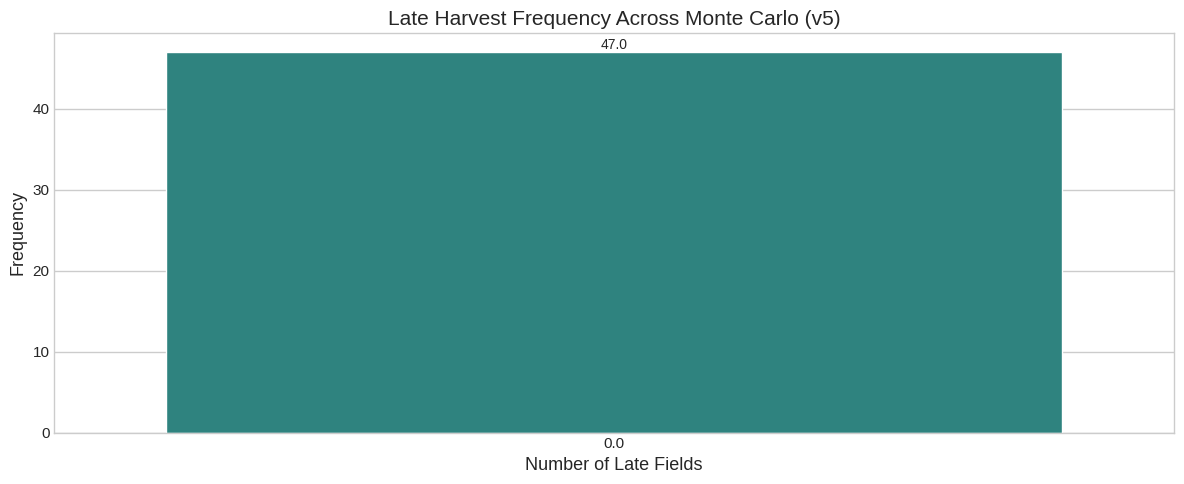

,late_harvests,count
0,0.0,47


In [16]:
plot_late_harvest_heatmap_v5("../../data/processed/monte_carlo_results_v5.csv")

Valid simulations (OK): 47 / 100

===== SUMMARY STATISTICS =====



,makespan,total_penalty,late_harvests
count,47.000000,47.0,47.0
mean,43.468085,0.0,0.0
std,0.584252,0.0,0.0
min,41.999999,0.0,0.0
50%,43.999999,0.0,0.0
90%,44.000000,0.0,0.0
95%,44.000000,0.0,0.0
max,44.000000,0.0,0.0


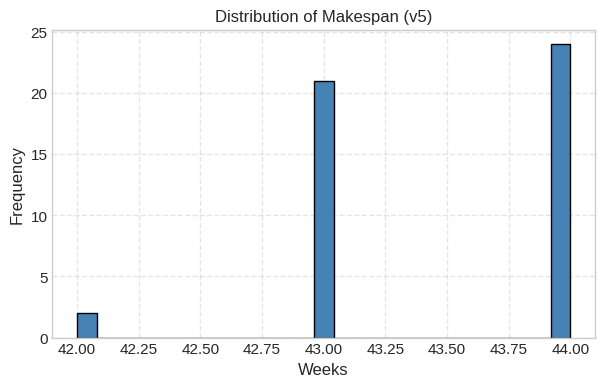

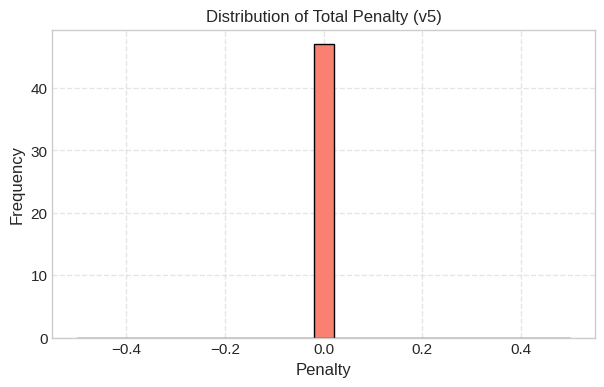

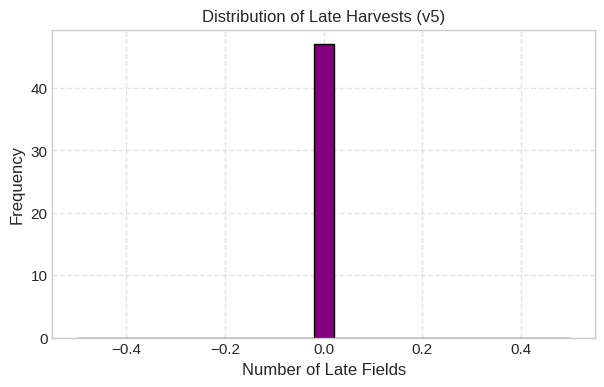

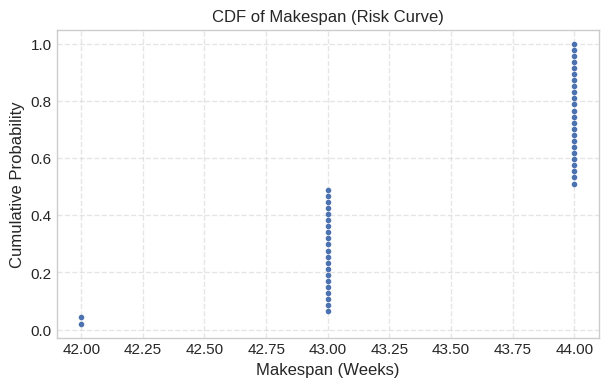

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -----------------------------------------------------------
# 1. LOAD + CLEAN RESULTS
# -----------------------------------------------------------

# Filter to *successful* MILP runs only
clean_df = results_df[results_df["status"] == "OK"].copy()

print(f"Valid simulations (OK): {len(clean_df)} / {len(results_df)}")

# -----------------------------------------------------------
# 2. SUMMARY STATISTICS
# -----------------------------------------------------------

summary_stats = clean_df[["makespan", "total_penalty", "late_harvests"]].describe(
    percentiles=[0.50, 0.90, 0.95]
)

print("\n===== SUMMARY STATISTICS =====\n")
display(summary_stats)

# -----------------------------------------------------------
# 3. HISTOGRAMS
# -----------------------------------------------------------

# --------- Makespan ----------
plt.figure(figsize=(7,4))
plt.hist(clean_df["makespan"], bins=25, color="steelblue", edgecolor="black")
plt.title("Distribution of Makespan (v5)")
plt.xlabel("Weeks")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --------- Total Penalty ----------
plt.figure(figsize=(7,4))
plt.hist(clean_df["total_penalty"], bins=25, color="salmon", edgecolor="black")
plt.title("Distribution of Total Penalty (v5)")
plt.xlabel("Penalty")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --------- Late Harvest Count ----------
plt.figure(figsize=(7,4))
plt.hist(clean_df["late_harvests"], bins=25, color="purple", edgecolor="black")
plt.title("Distribution of Late Harvests (v5)")
plt.xlabel("Number of Late Fields")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# -----------------------------------------------------------
# 4. MAKESPAN CDF (RISK CURVE)
# -----------------------------------------------------------

sorted_makespan = clean_df["makespan"].sort_values().values
cdf = np.arange(1, len(sorted_makespan)+1) / len(sorted_makespan)

plt.figure(figsize=(7,4))
plt.plot(sorted_makespan, cdf, marker=".", linestyle="none")
plt.title("CDF of Makespan (Risk Curve)")
plt.xlabel("Makespan (Weeks)")
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Found 100 simulation-weekly files (v5).


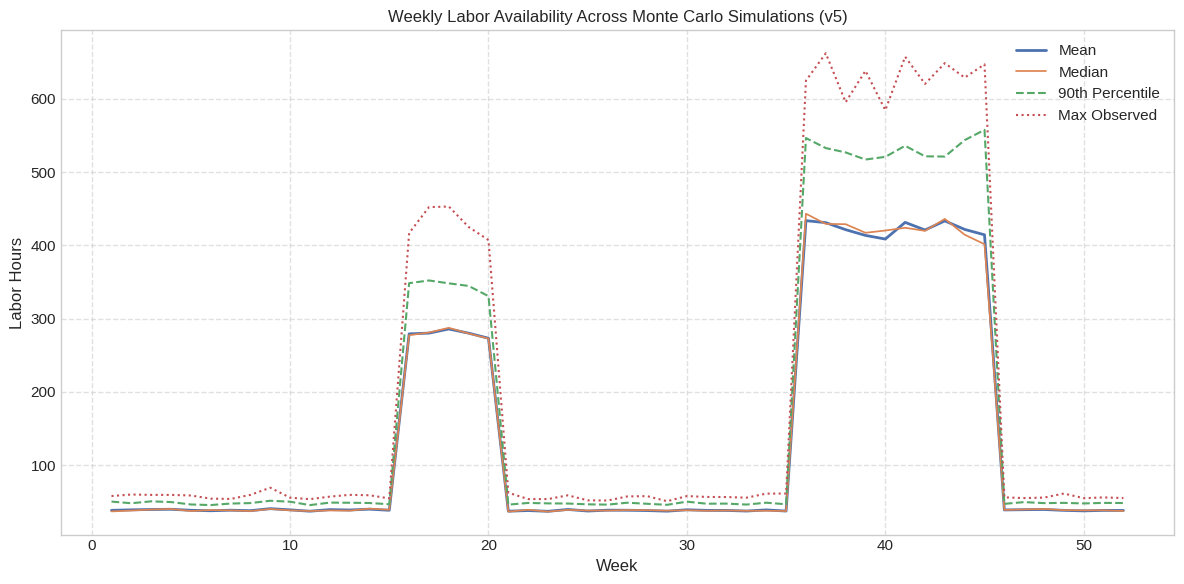

,mean_labor,median_labor,std_labor,p90_labor,max_labor
week,,,,,
1,38.135000,36.667522,8.139159,50.080061,57.671812
2,38.829548,37.887442,7.549794,47.829053,59.729516
3,39.284609,39.226830,8.297762,50.419890,59.230096
4,39.594759,39.995957,7.440207,49.434138,59.198705
5,38.195511,37.210652,6.946255,46.160803,58.419522


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# ============================================
# 1. Load all weekly simulation files (v5)
# ============================================

sim_files = sorted(glob.glob("../../data/processed/mc_v5/weekly_sim_*.csv"))

print(f"Found {len(sim_files)} simulation-weekly files (v5).")

# ============================================
# 2. Aggregate labor by week
# ============================================

weekly_labor = {}

for file in sim_files:
    df = pd.read_csv(file)

    # Keep only target year
    df = df[df["year"] == 2017]

    # Aggregate
    for _, row in df.iterrows():
        w = int(row["week"])
        labor_val = float(row["labor_hours"])

        weekly_labor.setdefault(w, []).append(labor_val)

# ============================================
# 3. Convert to DataFrame
# ============================================

weeks_sorted = sorted(weekly_labor.keys())

labor_df = pd.DataFrame({
    "week": weeks_sorted,
    "mean_labor":   [np.mean(weekly_labor[w]) for w in weeks_sorted],
    "median_labor": [np.median(weekly_labor[w]) for w in weeks_sorted],
    "std_labor":    [np.std(weekly_labor[w]) for w in weeks_sorted],
    "p90_labor":    [np.percentile(weekly_labor[w], 90) for w in weeks_sorted],
    "max_labor":    [np.max(weekly_labor[w]) for w in weeks_sorted],
})

labor_df = labor_df.set_index("week")

# ============================================
# 4. Plot – Weekly Labor Pressure Across MC Runs
# ============================================

plt.figure(figsize=(12, 6))
plt.plot(labor_df["mean_labor"],   label="Mean",  linewidth=2)
plt.plot(labor_df["median_labor"], label="Median", linewidth=1.25)
plt.plot(labor_df["p90_labor"],    label="90th Percentile", linestyle="--")
plt.plot(labor_df["max_labor"],    label="Max Observed", linestyle=":")

plt.title("Weekly Labor Availability Across Monte Carlo Simulations (v5)")
plt.xlabel("Week")
plt.ylabel("Labor Hours")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

labor_df.head()


Valid simulations: 47 / 100


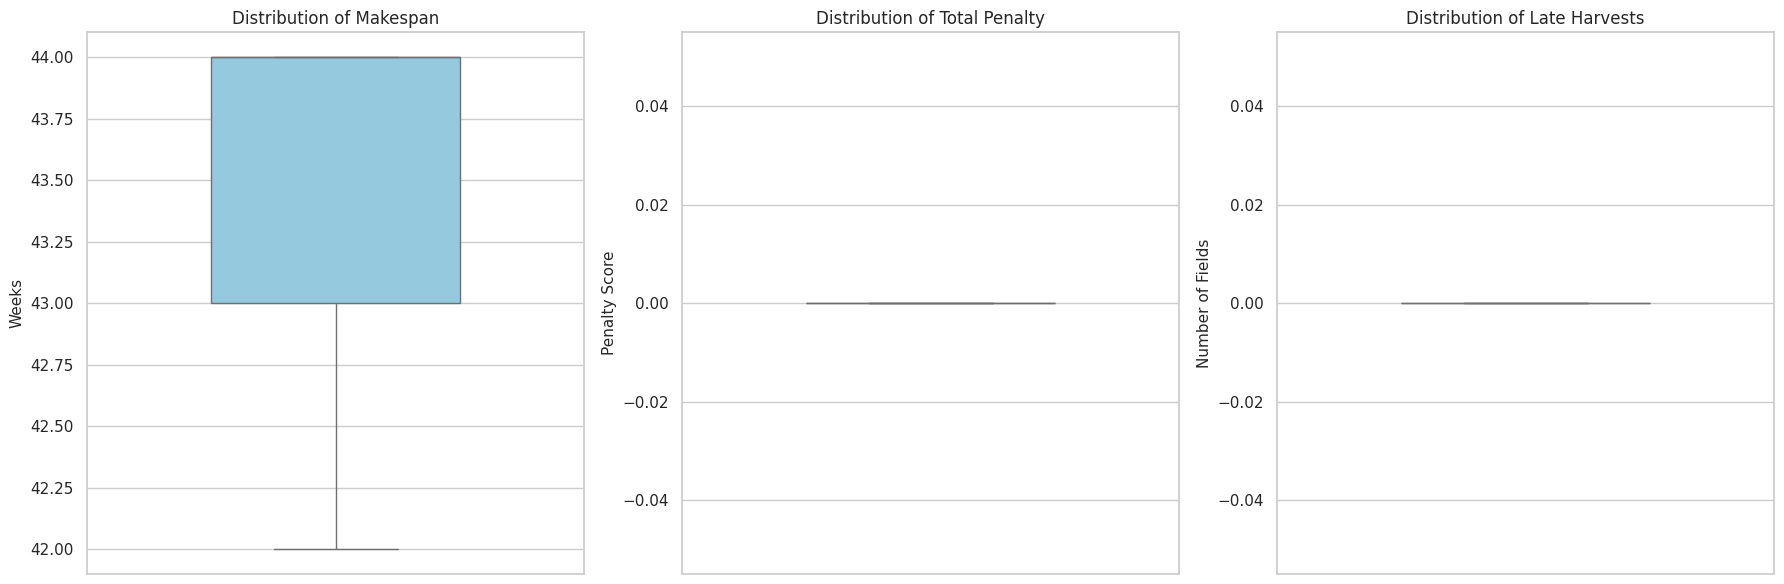

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 1. Clean only successful simulations
# -------------------------------------
clean_results = results_df[
    (results_df["status"] == "OK") &
    results_df[["makespan", "total_penalty", "late_harvests"]].notna().all(axis=1)
]

print(f"Valid simulations: {len(clean_results)} / {len(results_df)}")

# -------------------------------------
# 2. Plot layout
# -------------------------------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Plot 1: Makespan
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="makespan",
    ax=axes[0],
    color="skyblue",
    width=0.5,
    fliersize=3
)
axes[0].set_title("Distribution of Makespan", fontsize=12)
axes[0].set_ylabel("Weeks", fontsize=11)
axes[0].set_xlabel("")

# ---------------------------------------------------------
# Plot 2: Total Penalty
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="total_penalty",
    ax=axes[1],
    color="lightcoral",
    width=0.5,
    fliersize=3
)
axes[1].set_title("Distribution of Total Penalty", fontsize=12)
axes[1].set_ylabel("Penalty Score", fontsize=11)
axes[1].set_xlabel("")

# ---------------------------------------------------------
# Plot 3: Late Harvests
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="late_harvests",
    ax=axes[2],
    color="lightgreen",
    width=0.5,
    fliersize=3
)
axes[2].set_title("Distribution of Late Harvests", fontsize=12)
axes[2].set_ylabel("Number of Fields", fontsize=11)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()


Valid simulations: 47 / 100


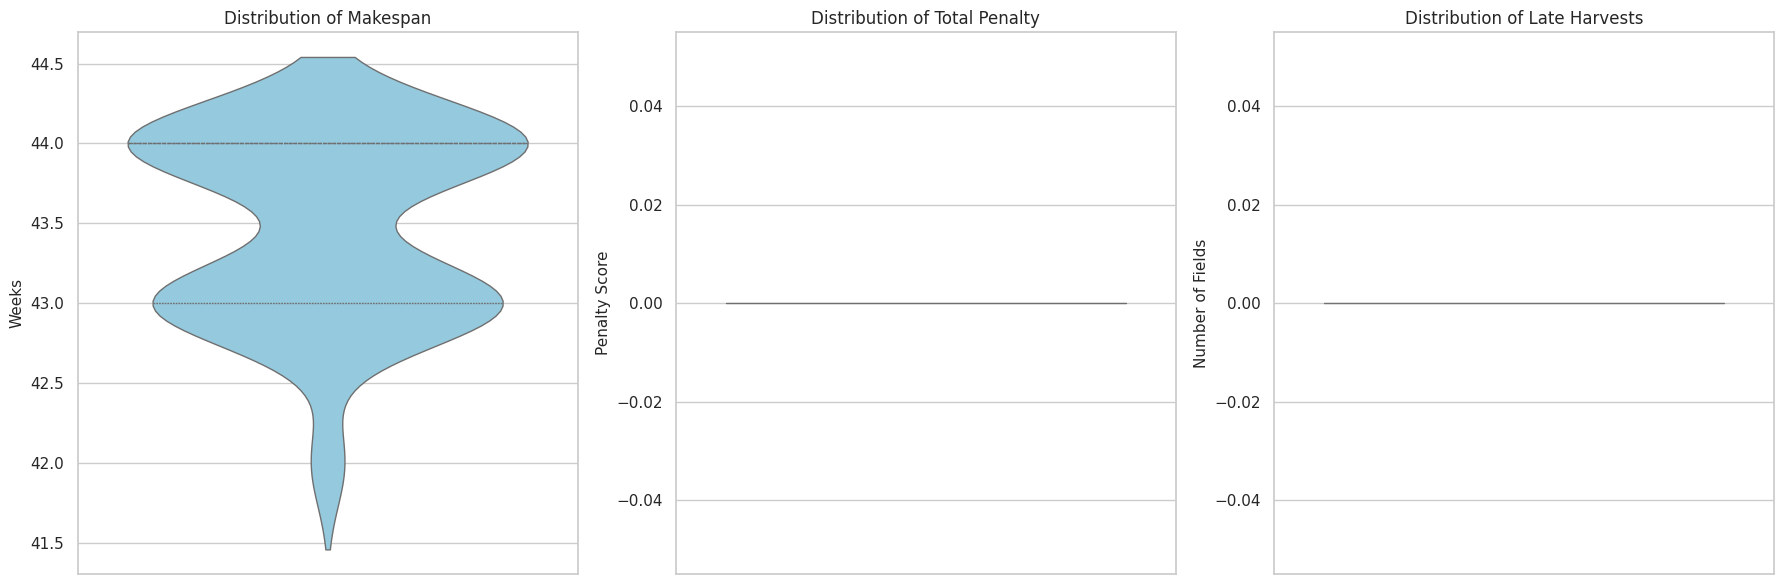

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. KEEP ONLY CLEAN, SUCCESSFUL SIMULATIONS
# ---------------------------------------------------------
clean_results = results_df[
    (results_df["status"] == "OK") &
    results_df[["makespan", "total_penalty", "late_harvests"]].notna().all(axis=1)
]

print(f"Valid simulations: {len(clean_results)} / {len(results_df)}")

# ---------------------------------------------------------
# 2. VIOLIN PLOTS
# ---------------------------------------------------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Plot 1: Makespan
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="makespan",
    ax=axes[0],
    color="skyblue",
    linewidth=1,
    inner="quartile"
)
axes[0].set_title("Distribution of Makespan", fontsize=12)
axes[0].set_ylabel("Weeks", fontsize=11)
axes[0].set_xlabel("")

# ---------------------------------------------------------
# Plot 2: Total Penalty
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="total_penalty",
    ax=axes[1],
    color="lightcoral",
    linewidth=1,
    inner="quartile"
)
axes[1].set_title("Distribution of Total Penalty", fontsize=12)
axes[1].set_ylabel("Penalty Score", fontsize=11)
axes[1].set_xlabel("")

# ---------------------------------------------------------
# Plot 3: Late Harvests
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="late_harvests",
    ax=axes[2],
    color="lightgreen",
    linewidth=1,
    inner="quartile"
)
axes[2].set_title("Distribution of Late Harvests", fontsize=12)
axes[2].set_ylabel("Number of Fields", fontsize=11)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()
